# Predicción del precio en Airbnb

## Selección de características

### Librerías

In [1]:
## IMPORTS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# https://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib inline 

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Leemos dataframe de train limpio
airbnb = pd.read_csv('./train_clean.csv', sep=';', decimal='.')

### Selección de características

**Regularización Lasso**

Se va a entrenar inicialmente un modelo de regresión lineal con Lasso a modo de método embebido para selección de características

In [3]:
# Métodos embedded

# convertimos el DataFrame al formato necesario para scikit-learn
lista_cols = airbnb.columns.tolist()
lista_cols.remove('Price')
airbnb_data = airbnb[['Price'] + lista_cols]

data = airbnb_data.values

y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto

feature_names = airbnb_data.columns[1:]

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

print('Datos entrenamiento: ', X_train.shape)
#print('Datos test: ', X_test.shape)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
#XtestScaled = scaler.transform(X_test)

Datos entrenamiento:  (10540, 48)


best mean cross-validation score: -1480.520
best parameters: {'alpha': 0.04832930238571752}


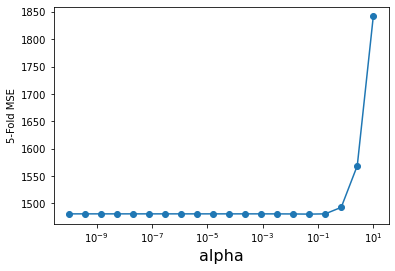

In [5]:
# Usamos Lasso como método embebido para seleccionar variables
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-10,1,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

Probamos Lasso de nuevo considerando la variable objetivo como log(Price), ya que, si visualizamos la distribución de los valores tomando logaritmos se aproxima algo más a una distribución normal

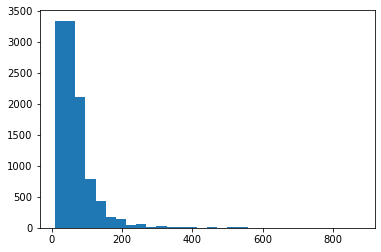

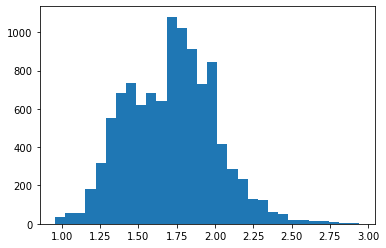

In [6]:
plt.hist(airbnb['Price'], bins=30)
plt.show()

plt.hist(np.log10(airbnb['Price']), bins=30)
plt.show()

best mean cross-validation score: -0.136
best parameters: {'alpha': 0.0008858667904100832}


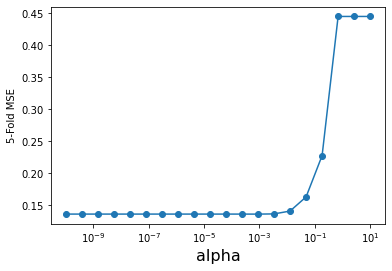

In [7]:
y_train = np.log(data[:,0:1])     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto

feature_names = airbnb_data.columns[1:]

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

alpha_vector = np.logspace(-10,1,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

**Random Forest**

Entrenamos también un modelo **Random Forest** para seleccionar características a partir de la importancia de las variables

best mean cross-validation score: 0.781
best parameters: {'max_depth': 19}


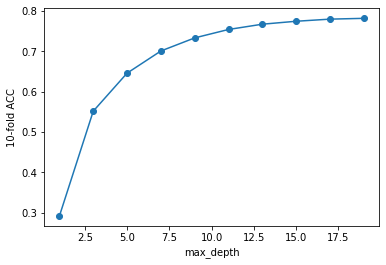

In [8]:
# Random forest para selección de características
from sklearn.ensemble import RandomForestRegressor

# grid search
maxDepth = range(1,20,2)
#n_estim = [250, 200, 250]

tuned_parameters = {'max_depth': maxDepth} 
                    

gs = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), 
                    param_grid=tuned_parameters,cv=10) #n_estimators=200,
gs.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(gs.best_score_))
print("best parameters: {}".format(gs.best_params_))

scores = np.array(gs.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [9]:
# El valor de 'max_depth' obtenido es muy elevado, nos devuelve un modelo demasiado complejo.
# Nos quedamos con un valor más bajo que devuelva un modelo más sencillo aunque se pierdan prestaciones.
maxDepthOptimo = 10 #gs.best_params_['max_depth']
rfModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",rfModel.score(X_train,y_train))

Train:  0.8086037119694198


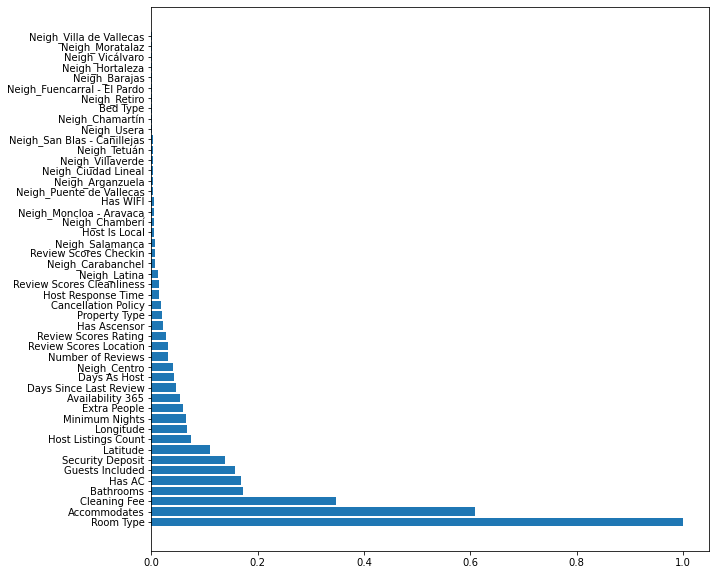

In [10]:
importances = rfModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

In [11]:
# Variables seleccionadas
sel_var = feature_names[indices][0:25]
sel_var

Index(['Room Type', 'Accommodates', 'Cleaning Fee', 'Bathrooms', 'Has AC',
       'Guests Included', 'Security Deposit', 'Latitude',
       'Host Listings Count', 'Longitude', 'Minimum Nights', 'Extra People',
       'Availability 365', 'Days Since Last Review', 'Days As Host',
       'Neigh_Centro', 'Number of Reviews', 'Review Scores Location',
       'Review Scores Rating', 'Has Ascensor', 'Property Type',
       'Cancellation Policy', 'Host Response Time',
       'Review Scores Cleanliness', 'Neigh_Latina'],
      dtype='object')

Probamos otra forma de seleccionar características con el ranking siguiente:

In [12]:
from sklearn.model_selection import KFold

N,Nfeatures = X_train.shape

rf = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt')

kf  = KFold(n_splits=10, shuffle = True, random_state=1)
cv_error = []
cv_std = []

for nfeatures in range(Nfeatures,0,-1):
        
    error_i = []
    
    for idxTrain, idxVal in kf.split(X_train):
        
        Xt = X_train[idxTrain,:]
        yt = y_train[idxTrain]
        Xv = X_train[idxVal,:]
        yv = y_train[idxVal]
        
        rf.fit(Xt,yt)
        
        ranking = rf.feature_importances_
        indices = np.argsort(ranking)[::-1] 
    
        selected = indices[0:(Nfeatures-nfeatures+1)]
        
        Xs = Xt[:,selected]
        
        rf.fit(Xs,yt)
        error = (1.0-rf.score(Xv[:,selected],yv))     
        error_i.append(error) 
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))
    
    print('# features ' + str(len(selected)) + ' error ' + str(np.mean(error_i)) + ' +/- ' + str(np.std(error_i)))

# features 1 error 0.5035232317779428 +/- 0.023197262192091422
# features 2 error 0.39548642772626535 +/- 0.023275995954975585
# features 3 error 0.34233717045824863 +/- 0.019936236033672092
# features 4 error 0.33039620932406144 +/- 0.021913669411310385
# features 5 error 0.31900532459554126 +/- 0.019909008795938408
# features 6 error 0.30569410169869515 +/- 0.020665551362264844
# features 7 error 0.2906342531420111 +/- 0.026288120201651468
# features 8 error 0.2816124582021058 +/- 0.022351493016027756
# features 9 error 0.27154608742406544 +/- 0.0240160465238315
# features 10 error 0.2635348999518996 +/- 0.023764730204167993
# features 11 error 0.2585174190676958 +/- 0.025308192347020156
# features 12 error 0.2522032237679951 +/- 0.020276457635267753
# features 13 error 0.2422875594758262 +/- 0.01871294495741106
# features 14 error 0.2414710523905635 +/- 0.016306089581732238
# features 15 error 0.24221380427093592 +/- 0.01631480692062015
# features 16 error 0.23806238536437596 +/- 0.

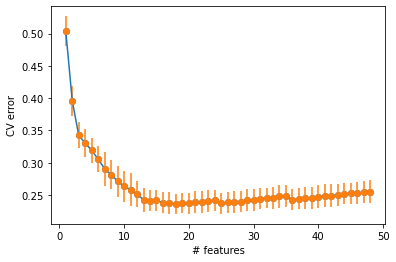

In [13]:
plt.plot(range(1,Nfeatures+1,1),cv_error,'-o')
plt.errorbar(range(1,Nfeatures+1,1), cv_error, yerr=cv_std, fmt='o')
plt.xlabel('# features')
plt.ylabel('CV error')
plt.show()

Con esta forma de selección de características, el valor mínimo de error se encuentra en el caso de 18 características. Se entrenarán modelos con 18 y con 25 características para ver con cuál se obtienen mejores resultados.

### Validación del conjunto de test con Lasso

Se va a comprobar la respuesta de este primer modelo de regresión lineal usando regularización de Lasso

In [15]:
# Leemos el conjunto de test previamente limpiado y preprocesado
test = pd.read_csv('./test_clean.csv', sep=';', decimal='.')

In [16]:
# convertimos el DataFrame al formato necesario para scikit-learn
#lista_cols_test = test.columns.tolist()
#lista_cols_test.remove('Price')
test_data = test[['Price'] + lista_cols]

In [17]:
# Validación Lasso

test_val = test_data.values

y_test = np.log(test_val[:,0:1])     # nos quedamos con la 1ª columna, price
X_test = test_val[:,1:]      # nos quedamos con el resto

feature_names = test_data.columns[1:]

print('Datos test: ', X_test.shape)

# Escalamos los datos de test
XtestScaled = scaler.transform(X_test)


Datos test:  (2650, 48)


In [18]:
from sklearn.metrics import mean_squared_error

print(grid.best_params_)
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)

mseTrainModelLasso = mean_squared_error(np.exp(y_train),np.exp(ytrainLasso))
mseTestModelLasso = mean_squared_error(np.exp(y_test),np.exp(ytestLasso))

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

{'alpha': 0.0008858667904100832}
MSE Modelo Lasso (train): 1.47e+03
MSE Modelo Lasso (test) : 1.41e+03
RMSE Modelo Lasso (train): 38.3
RMSE Modelo Lasso (test) : 37.6
Host Response Time -0.00039160057526962814
Host Listings Count 0.004302170722640181
Latitude 0.048649120251842974
Longitude -0.007393597040852904
Property Type -0.008911945710474146
Room Type 0.29663551343133615
Accommodates 0.16596578902624567
Bathrooms 0.04849539995646089
Bed Type 0.012849876028418753
Guests Included 0.03964660170221599
Extra People -0.045468648989060105
Minimum Nights -0.02635752905333939
Availability 365 0.04593644022295496
Number of Reviews -0.03789047303911153
Review Scores Rating 0.03730440294277587
Review Scores Cleanliness 0.019808659709913967
Review Scores Checkin -0.0015147724832821447
Review Scores Location 0.013790156864904233
Cancellation Policy -0.028677415370550623
Security Deposit 0.018245778414150465
Cleaning Fee 0.09843806533089797
Neigh_Arganzuela 0.0
Neigh_Barajas 0.0
Neigh_Carabanche

Con la regularización de Lasso se desactivan solo características.
Si observamos el error cuadrático medio (RMSE) y la media de la variable precio vemos que el modelo aplicado está cometiendo un error de más del 50%